The purpose of this note book is to demonstrate how teh profit optimisation model works.

The code bellow imports all relevant python packages

In [1]:
import sys
sys.path.append('../')

from src.cumulative_Weibull_distribution_model import cumulative_weibull_distribution_from_conductance_loss_at_given_water_potentials, CumulativeWeibullDistribution
from src.hydraulic_cost_model import HydraulicCostModel
from src.leaf_air_coupling_model import LeafAirCouplingModel
from src.rubisco_CO2_and_O_model import RubiscoRates
from src.photosynthesis_model import PhotosynthesisModelRubiscoLimited, PhotosynthesisModelElectronTransportLimited, PhotosynthesisModel
from src.CO2_gain_model import CO2GainModel
from src.profit_optimisation_model import ProfitOptimisationModel
from src.electron_transport_rate_model import ElectronTransportRateModel

from src.TemperatureDependenceModels.arrhenius_and_peaked_arrhenius_function import ArrheniusModel, PeakedArrheniusModel
from src.TemperatureDependenceModels.Q10_temperature_dependence_model import Q10TemperatureDependenceModel
from src.TemperatureDependenceModels.temperature_dependence_model import LowTemperatureAdjustedModel

from src.conversions import degrees_centigrade_to_kelvin

from numpy import linspace, zeros
from numpy import argmax
from matplotlib import pyplot as plt

# The Model

The core principle of the model is that the plant acts to maximise its photosynthesis rate while minimising the damage to xylem due to water stress. This principle is modeld using a profit maximisation approach. The profit of the system is defiend as the net gain in carbon $CG(\psi_{leaf})$ minus the hydraulic cost $HC(\psi_{leaf})$. The leaf adjusting the stomata to achive the leaf water potential $\psi_{leaf}$ that maximises the profit.


$$ \text{Profit}_{\text{max}} = \text{max}(CG(\psi_{leaf}) - HC(\psi_{leaf})) $$

# Hydraulic cost

The hydraulic cost of the plan reflects the increased potential for xylem damage due to a loss of hydraulic conductance:

$$ HC(\psi_{leaf}) = \frac{k_{i,max} - k(\psi_{leaf})}{k_{i,max} - k_{crit}} $$

Here $k(\psi)$ is the hydraulic conductance at a given water potential, $k_{i,max}$ is the maximum potential conductance at a given instance in time (i.e the conductance evaluated at the soil water potential) and $k_{crit}$ is the conductance that induses xylem failure.

## Hydraulic conductance

Before we can calculate the hydraulic cost it is necessary to create a model of hydraulic conductance, this is achived by using a cummulative Weibull distribution,

$$ k(\psi) = k_{max}e^{-(\psi/b)^c} $$

Here $k_{max}$ is the maximum possible conductance at a water potential of zero, $b$ is the sensetivity of the funcion to changes in water ptotential and $c$ is some shape paramiter. The values of $k_{max}$, $b$ and $c$ are dependent on the tree being modeled. Specificaly the values of $b$ and $c$ are calcuated based on the water potentials coresponding to two fractional losses of conductance ($k(\psi)/k_{max}$). For example Juniperus virginiana suffers a conductance loss of $50\%$ at $-6.6MPa$ and $88\%$ at $-10.5MPa$.

The code bellow plots the hdraulic conductance as a function of water potential.

critical leaf water potential:  -5.726712942005315 mmol m-2 s-1 MPa-1


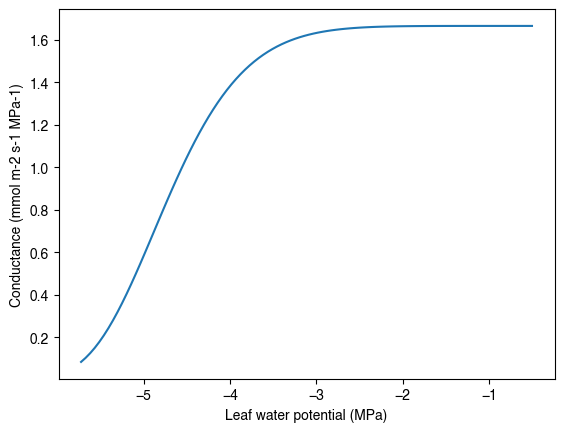

In [2]:
# Conductance model
'''P50 = - 6.6 # MPa
P88 = -10.5 # MPa
k_max = 0.2 # mmol m-2 s-1 MPa-1

conductance_model = cumulative_weibull_distribution_from_conductance_loss_at_given_water_potentials(k_max,
                                                                                                    P50,
                                                                                                    P88,
                                                                                                    0.5,
                                                                                                    0.88)'''


conductance_model = \
    CumulativeWeibullDistribution(maximum_conductance = 1.6659, # mmol m-2 s-1 MPa-1
                                  sensitivity_parameter = -4.969847639573251, # MPa
                                  shape_parameter = 7.740170420442604) # unitless

# Water potential range
soil_water_potential = -0.5 # MPa
critical_water_potential = conductance_model.water_potential_from_conductivity_loss_fraction(0.95) # MPa
water_potentials = linspace(soil_water_potential, critical_water_potential, 100)

print("critical leaf water potential: ", critical_water_potential, "mmol m-2 s-1 MPa-1")

# Conductances
conductances = conductance_model.conductance(water_potentials)

# Ploting
plt.plot(water_potentials, conductances)
plt.xlabel("Leaf water potential (MPa)")
plt.ylabel("Conductance (mmol m-2 s-1 MPa-1)")
plt.show()

Having modeled the trees hydraulic conductance we can now use this to calcualte the hydraulic cost as a function of leaf water potential.

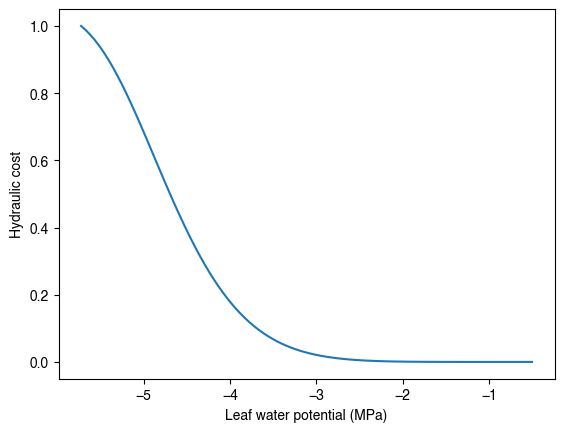

In [3]:
hydraulic_cost_model = HydraulicCostModel(conductance_model, critical_water_potential)

hydraulic_costs = hydraulic_cost_model.hydraulic_cost_as_a_function_of_leaf_water_potential(water_potentials, 
                                                                                            soil_water_potential)

# Plotting
plt.plot(water_potentials, hydraulic_costs)
plt.xlabel("Leaf water potential (MPa)")
plt.ylabel("Hydraulic cost")
plt.show()

# Transpiration

Assuming that the tree exists in a steady state, the rate of flow of water from the soil to the leaf is equal to that from the leaf to the air through transpiration. The rate of flow from the soil to the leaf is given by the integral,

$$ E(\psi_{leaf}) = \int_{\psi_{soil}}^{\psi_{leaf}} k(\psi) d\psi $$

The code bellow plots transpiration as a function of leaf water potential

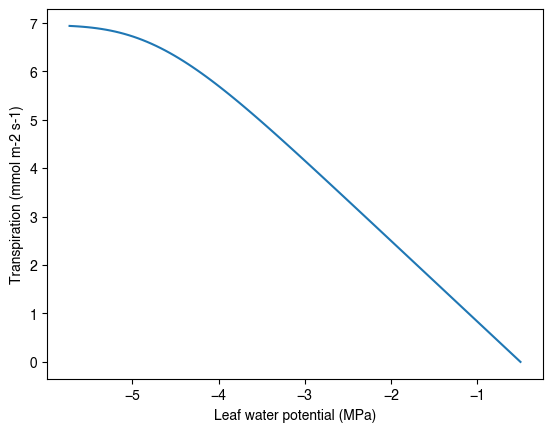

In [4]:
transpiration_values = zeros(len(water_potentials))

for i in range(len(water_potentials)):
    transpiration_values[i] = hydraulic_cost_model.transpiration(water_potentials[i], soil_water_potential, steps = 100)

plt.plot(water_potentials, transpiration_values)
plt.xlabel("Leaf water potential (MPa)")
plt.ylabel("Transpiration (mmol m-2 s-1)")
plt.show()

## Stomatal conductance

The equation for transpiration from the leaf via the sromata is

$$ E = \frac{e_{sat}(T_{leaf}) - e_{air}}{P_{air}} g_{lw} $$

where $e_{sat}(T_{leaf})$ is the vapour pressure of the air within the stomata (this air having the same temperature as the leaf), $e_{air}$ is the vapour pressure of the air, $P_{air}$ is the air pressure and $g_{lw}$ is the conductance to water between the leaf and the atmostphere.

We make two simlifying asumptions to this equation. First we asume perfect leaf atmostphere coupling such that the only restriction to the flow of water from the leaf to the air is the stomatal conductance meaning that $g_{lw} \rightarrow g_{sw}$. The second asumption is that the temperature of the leaf is equal to that of the air. This means that the vapour pressure within the stomata is equal to the saturatd vapour pressure of the air, $e_{sat}(T_{air})$. In masking this substitution the difference in vapour pressure is now equal to the vapour pressure deficit $\text{VPD} = e_{sat}(T_{air}) - e_{air}$.

Given this we can use the transpiration rate calculated previously along with measurments of air pressure and vapour pressure deficit to get the stomatal conductance to water. It is then trivial to convert to the stomatal conductance to carbon by multiplying by their ration ($1.57$)

The stomatal conductance to water and carbon as a function of leaf water potential is plotted below.

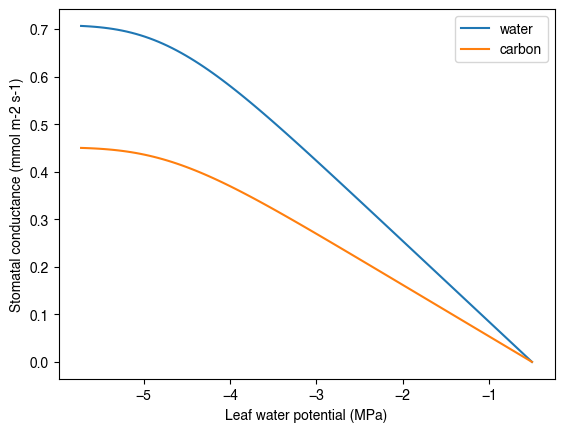

In [5]:
air_temperature = degrees_centigrade_to_kelvin(25.)
air_vapour_pressure_deficit = 1 # kPa
air_pressure = 101.9 # kPa

leaf_air_coupling_model = LeafAirCouplingModel()
stomatal_conductances_to_water = zeros(len(water_potentials))

for i in range(len(water_potentials)):
    stomatal_conductances_to_water[i] = leaf_air_coupling_model.stomatal_conductance_to_water(transpiration_values[i],
                                                                                              air_temperature,
                                                                                              air_vapour_pressure_deficit,
                                                                                              air_pressure)

# We want stomatal conductance in mol m-2 s-1 (currently mmol m-2 s-1)
stomatal_conductances_to_water /= 1000
    
stomatal_conductances_to_carbon = 1/1.57 * stomatal_conductances_to_water

plt.plot(water_potentials, stomatal_conductances_to_water, label = "water")
plt.plot(water_potentials, stomatal_conductances_to_carbon, label = "carbon")
plt.legend()
plt.xlabel("Leaf water potential (MPa)")
plt.ylabel("Stomatal conductance (mmol m-2 s-1)")
plt.show()

# Net carbon gain

By assuming that the system is in a steady state the net flow of carbon from the atmostphere into the leaf via the stomata is equal to the net uptake of carbon due to photosynthesis.

$$ A_n(c_i) = (c_a - c_i)g_{lc} $$

where $c_a$ and $c_i$ are the atmospheric and intercelular carbon consentrations respectivly and $g_{lc}$ is the leaf conductance to carbon calculated above. The problem with calculating $A_n$ directly from this equation is that we don't have measurment of $c_i$.

The net carbon uptake can alternativly be calculated from the $CO_2$ uptake during carboxylation $V_c$, $CO_2$ loss during oxygentation $V_o$ and $CO_2$ loss from mitochondrial respiration $R_d$.

$$ A_n(c_i) = V_c(c_i) - 0.5V_o(c_i) - R_d $$

This can be simplified by substituting in the $CO_2$ compensation point $\Gamma^*$ such that,

$$ A_n(c_i) = (1 - \frac{\Gamma^*}{c_i})V_c(c_i) - R_d $$

## Rubisco limiting

For simplicity we will asume that the net $CO_2$ uptake is describd wholy by the Rubisco-limited craboxylation rate,

$$ V_c(c_i) = \frac{V_{c \text{max}}c_i}{c_i + K} $$

where $K$ is the michaelis menten constant of carboxylation. Given this we have a second equation for carbon uptake as a funcion of intercellular $CO_2$.

$$ A_n(c_i) = (1 - \frac{\Gamma^*}{c_i})\frac{V_{c \text{max}}c_i}{c_i + K} - R_d $$

Combining the two equations for carbon uptake gives,

$$ (c_a - c_i)g_{lc} = (1 - \frac{\Gamma^*}{c_i})\frac{V_{c \text{max}}c_i}{c_i + K} - R_d $$

Rearanging this equation to solve for $c_i$ results in the following quadratic equation,

$$ -g_{lc} c_i^2 + ((c_a - k) g_{lc} + R_d - V_{cmax}) c_i + ((c_a g_{lc} + R_d)k + \Gamma^* V_{c \text{max}}) = 0 $$

The first step to calculating the net carbon uptake is hence to solve this quadratic for $c_i$. The code bellow solves for $c_i$ and plots the results as a function of water leaf potential.

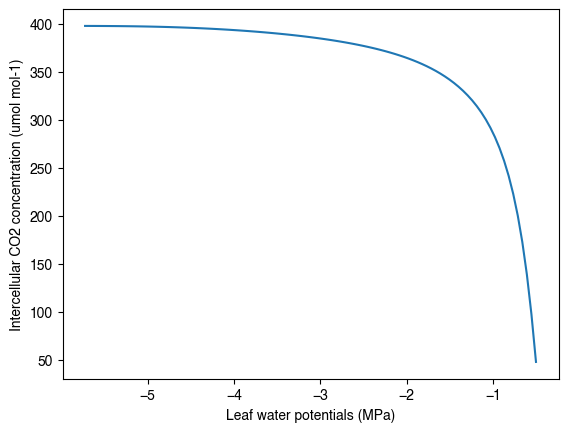

In [6]:
atmospheric_CO2_concentration = 419. # (umol mol-1)
intercellular_oxygen = 210.0 #(umol mol-1)

# -- Rubisco rates model --
maximum_carboxylation_rate_model = PeakedArrheniusModel(rate_at_25_centigrade = 30.,
                                                        activation_energy = 60000.,
                                                        deactivation_energy = 200000.,
                                                        entropy_term = 650.)

maximum_oxegentation_rate_model = PeakedArrheniusModel(rate_at_25_centigrade = 60.,
                                                       activation_energy = 3000.,
                                                       deactivation_energy = 200000.,
                                                       entropy_term = 650.)

michaelis_menten_constant_CO2_model = ArrheniusModel(rate_at_25_centigrade=404.9,
                                                     activation_energy=79430.0)

michaelis_menten_constant_O_model = ArrheniusModel(rate_at_25_centigrade=278.4,
                                                   activation_energy=36380.0)

rubisco_rates_model = RubiscoRates(maximum_carboxylation_rate_model,
                                   maximum_oxegentation_rate_model,
                                   michaelis_menten_constant_CO2_model,
                                   michaelis_menten_constant_O_model)

# -- CO2 compensation point --
CO2_compensation_point_model = ArrheniusModel(rate_at_25_centigrade = 42.75,
                                            activation_energy = 37830.0)

# -- mitochondrial respiration rate model --
mitochondrial_respiration_rate_model = Q10TemperatureDependenceModel(value_at_25C = 0.2,
                                                                     Q10_parameter = 2.)

# -- Rubisco limited model --
photosynthesis_model_rubisco_limited = PhotosynthesisModelRubiscoLimited(rubisco_rates_model = rubisco_rates_model,
                                                                         CO2_compensation_point_model = CO2_compensation_point_model,
                                                                         mitochondrial_respiration_rate_model = mitochondrial_respiration_rate_model)

intercellular_CO2_concentrations_rubisco_limited = zeros(len(water_potentials))

for i in range(len(water_potentials)):
    intercellular_CO2_concentrations_rubisco_limited[i] = \
        photosynthesis_model_rubisco_limited.intercellular_CO2_concentration(stomatal_conductances_to_carbon[i],
                                                                             atmospheric_CO2_concentration,
                                                                             air_temperature,
                                                                             intercellular_oxygen)

plt.plot(water_potentials, intercellular_CO2_concentrations_rubisco_limited)
plt.xlabel("Leaf water potentials (MPa)")
plt.ylabel("Intercellular CO2 concentration (umol mol-1)")
plt.show()

Given a value for the intercellular $CO_2$ concentration, the net $CO_2$ asimilation rate can be caclulated using the difusion equation for $CO_2$ passing through the stomata,

$$ A_n = (c_a - c_i)g_{sc} $$

The code bellow plots this as a function of leaf water potential.

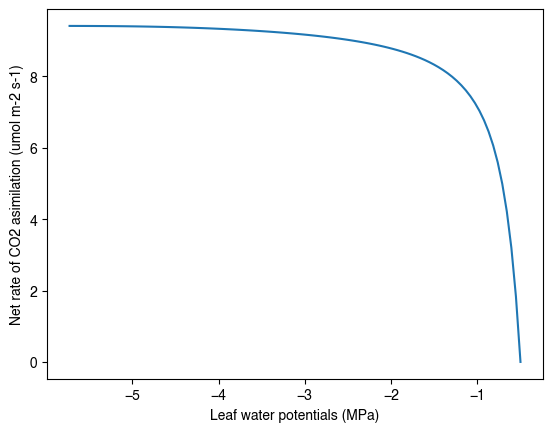

In [7]:
net_CO2_asimilation_rubisco_limited = zeros(len(water_potentials))

for i in range(len(water_potentials)):
    net_CO2_asimilation_rubisco_limited[i] = \
        photosynthesis_model_rubisco_limited.net_rate_of_CO2_assimilation(stomatal_conductances_to_carbon[i],
                                                                          atmospheric_CO2_concentration,
                                                                          air_temperature,
                                                                          intercellular_oxygen)

plt.plot(water_potentials, net_CO2_asimilation_rubisco_limited)
plt.xlabel("Leaf water potentials (MPa)")
plt.ylabel("Net rate of CO2 asimilation (umol m-2 s-1)")
plt.show()

To make use of the net $CO_2$ gain as a funtion of leaf water potential within the profit maximisation model we normalise the function by dividing by its maximum value over the range $[\psi_s, \psi_{crit}]$.

$$ \text{CG} = \frac{A_n(\psi_{leaf})}{\text{max}(A_n(\psi_{leaf}))} $$

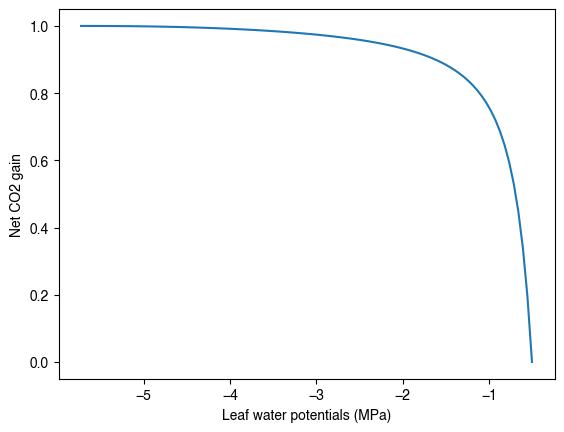

In [8]:
CO2_gain_model_rubisco_limited = CO2GainModel(leaf_air_coupling_model,
                                              photosynthesis_model_rubisco_limited)

carbon_gain_rubisco_limited, max_CO2_uptake_rubisco_limited = CO2_gain_model_rubisco_limited.CO2_gain(transpiration_values,
                                                                                                      air_temperature,
                                                                                                      air_vapour_pressure_deficit,
                                                                                                      air_pressure,
                                                                                                      atmospheric_CO2_concentration,
                                                                                                      intercellular_oxygen)

plt.plot(water_potentials, carbon_gain_rubisco_limited)
plt.xlabel("Leaf water potentials (MPa)")
plt.ylabel("Net CO2 gain")
plt.show()

## Electron transport limited photosyntheis

Alternativly we can use the same approach to calculate the CO2 uptake when the electron transport rate is the limiting factor. Instead of $V_c$ we use $V_j$.

$$ V_j = \frac{Jc_i}{4c_i + 8\Gamma^*} $$

The resulting quadratic equation for the intercellular $\text{CO}_2$ concentration is,

$$ -g_{lc}c_i^2 + (c_ag_{lc} + R_n - 2g_{lc}\Gamma^* - J/4)c_i + (2c_ag_{lc}\Gamma + 2R_n\Gamma^*+\Gamma^*J/4) = 0 $$

The code bellow compares the results of this model to the rubisco rate limited model when calculating the intercellular $\text{CO}_2$.

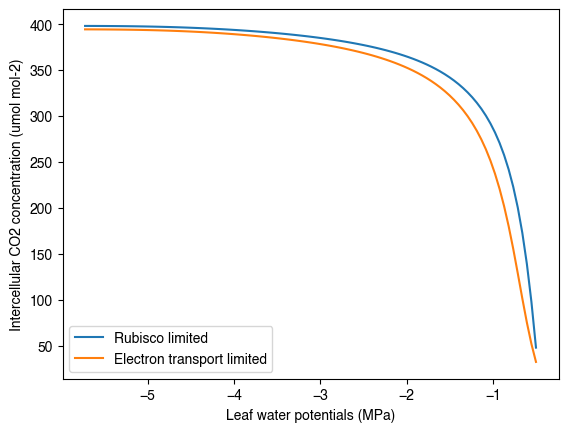

In [9]:
atmospheric_CO2_concentration = 419. # (umol mol-1)
photosyntheticaly_acitve_radiation = 1500. #(umol m-2 s-1)

maximum_electron_transport_rate_model = LowTemperatureAdjustedModel(PeakedArrheniusModel(rate_at_25_centigrade = 60., 
                                                                                         activation_energy = 30000., 
                                                                                         deactivation_energy = 200000., 
                                                                                         entropy_term = 650.),
                                                                   lower_bound_C = 0.,
                                                                   upper_bound_C = 10.)

electron_transport_rate_model = ElectronTransportRateModel(curvature_parameter = 0.85,
                                                           maximum_electron_transport_rate_model = maximum_electron_transport_rate_model)

photosynthesis_model_electron_transport_limited = PhotosynthesisModelElectronTransportLimited(electron_transport_rate_model = electron_transport_rate_model,
                                                                                              CO2_compensation_point_model = CO2_compensation_point_model,
                                                                                              mitochondrial_respiration_rate_model = mitochondrial_respiration_rate_model)

intercellular_CO2_concentrations_electron_transport_limited = zeros(len(water_potentials))

for i in range(len(water_potentials)):
    intercellular_CO2_concentrations_electron_transport_limited[i] = \
        photosynthesis_model_electron_transport_limited.intercellular_CO2_concentration(stomatal_conductances_to_carbon[i],
                                                                                        atmospheric_CO2_concentration,
                                                                                        air_temperature,
                                                                                        utilized_photosynthetically_active_radiation=photosyntheticaly_acitve_radiation)

plt.plot(water_potentials, intercellular_CO2_concentrations_rubisco_limited, label = 'Rubisco limited')
plt.plot(water_potentials, intercellular_CO2_concentrations_electron_transport_limited, label = 'Electron transport limited')
plt.legend()
plt.xlabel("Leaf water potentials (MPa)")
plt.ylabel("Intercellular CO2 concentration (umol mol-2)")
plt.show()

Comparing the net $\text{CO}_2$ asimilation.

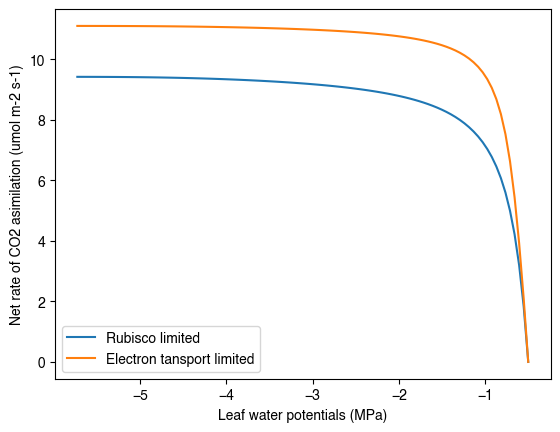

In [10]:
net_CO2_asimilation_electron_transport_limited = zeros(len(water_potentials))

for i in range(len(water_potentials)):
    net_CO2_asimilation_electron_transport_limited[i] = \
        photosynthesis_model_electron_transport_limited.net_rate_of_CO2_assimilation(stomatal_conductances_to_carbon[i],
                                                                                     atmospheric_CO2_concentration,
                                                                                     air_temperature,
                                                                                     utilized_photosynthetically_active_radiation=photosyntheticaly_acitve_radiation)

plt.plot(water_potentials, net_CO2_asimilation_rubisco_limited, label = 'Rubisco limited')
plt.plot(water_potentials, net_CO2_asimilation_electron_transport_limited, label = 'Electron tansport limited')
plt.legend()
plt.xlabel("Leaf water potentials (MPa)")
plt.ylabel("Net rate of CO2 asimilation (umol m-2 s-1)")
plt.show()

While the net $\text{CO}_2$ gain is compared bellow it is important to remember that the normalisation differs between the two.

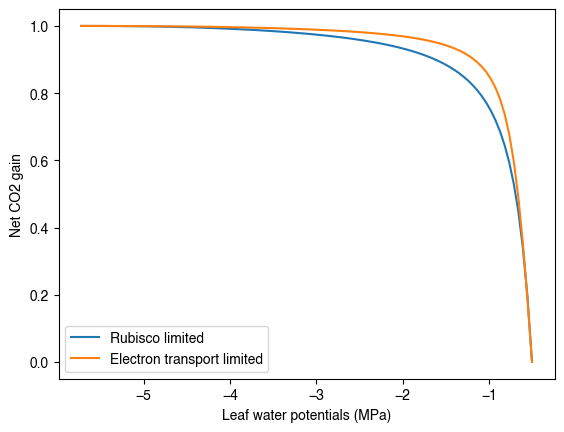

In [11]:
CO2_gain_model_electron_transport_limited = CO2GainModel(leaf_air_coupling_model,
                                              photosynthesis_model_electron_transport_limited)

carbon_gain_electron_transport_limited, max_CO2_uptake_electron_transport_limited = CO2_gain_model_electron_transport_limited.CO2_gain(transpiration_values,
                                                                                                                                       air_temperature,
                                                                                                                                       air_vapour_pressure_deficit,
                                                                                                                                       air_pressure,
                                                                                                                                       atmospheric_CO2_concentration,
                                                                                                                                       photosyntheticaly_active_radiation = photosyntheticaly_acitve_radiation)

plt.plot(water_potentials, carbon_gain_rubisco_limited, label = 'Rubisco limited')
plt.plot(water_potentials, carbon_gain_electron_transport_limited, label = 'Electron transport limited')
plt.legend()
plt.xlabel("Leaf water potentials (MPa)")
plt.ylabel("Net CO2 gain")
plt.show()

## Full photosynthesis model

To fully model photosynthesis we need to combine both the rubisco limited and electron transport limited models such that the net rate of $\text{CO}_2$ asimilation is the minimum of the two calculatd for the given set of conditions. With respect to calculating the intercellular $\text{CO}_2$ concentration this corresponds to the maximum value calculated for the two limiting models.

The code below plots the reslts of this compared to the two seperate models.

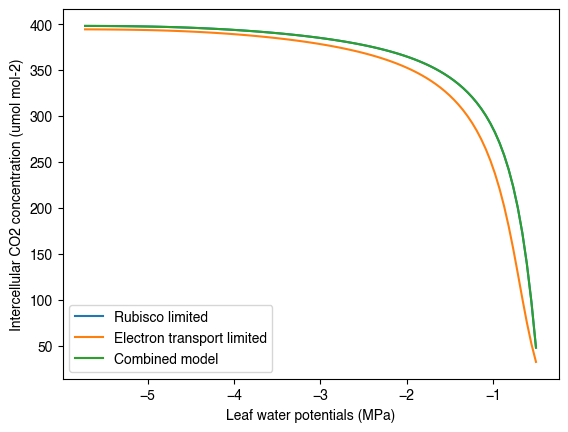

In [12]:
photosynthesis_model = PhotosynthesisModel()

intercellular_CO2_concentrations = zeros(len(water_potentials))

for i in range(len(water_potentials)):
    intercellular_CO2_concentrations[i] = \
        photosynthesis_model.intercellular_CO2_concentration(stomatal_conductances_to_carbon[i],
                                                             atmospheric_CO2_concentration,
                                                             air_temperature,
                                                             intercellular_oxygen,
                                                             photosyntheticaly_acitve_radiation)

plt.plot(water_potentials, intercellular_CO2_concentrations_rubisco_limited, label = 'Rubisco limited')
plt.plot(water_potentials, intercellular_CO2_concentrations_electron_transport_limited, label = 'Electron transport limited')
plt.plot(water_potentials, intercellular_CO2_concentrations, label = 'Combined model')
plt.legend()
plt.xlabel("Leaf water potentials (MPa)")
plt.ylabel("Intercellular CO2 concentration (umol mol-2)")
plt.show()

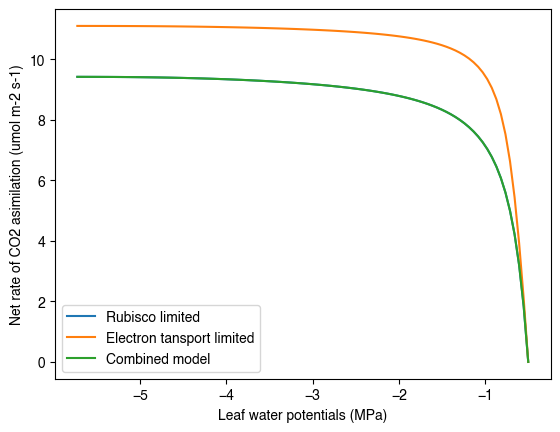

In [13]:
net_CO2_asimilation = zeros(len(water_potentials))

for i in range(len(water_potentials)):
    net_CO2_asimilation[i] = \
        photosynthesis_model.net_rate_of_CO2_assimilation(stomatal_conductances_to_carbon[i],
                                                          atmospheric_CO2_concentration,
                                                          air_temperature,
                                                          intercellular_oxygen,
                                                          photosyntheticaly_acitve_radiation)

plt.plot(water_potentials, net_CO2_asimilation_rubisco_limited, label = 'Rubisco limited')
plt.plot(water_potentials, net_CO2_asimilation_electron_transport_limited, label = 'Electron tansport limited')
plt.plot(water_potentials, net_CO2_asimilation, label = 'Combined model')
plt.legend()
plt.xlabel("Leaf water potentials (MPa)")
plt.ylabel("Net rate of CO2 asimilation (umol m-2 s-1)")
plt.show()

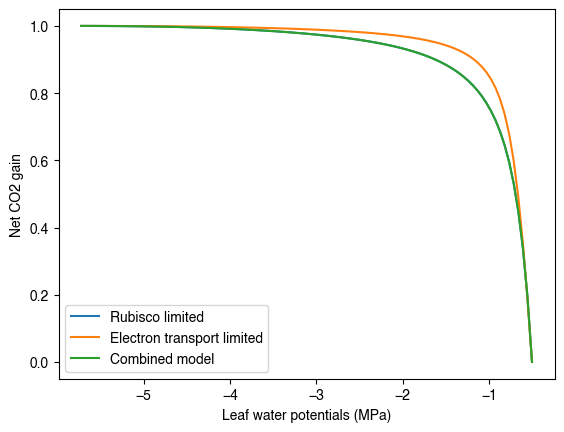

In [14]:
CO2_gain_model = CO2GainModel(leaf_air_coupling_model,
                              photosynthesis_model)

carbon_gain, max_CO2_uptake = CO2_gain_model.CO2_gain(transpiration_values,
                                                      air_temperature,
                                                      air_vapour_pressure_deficit,
                                                      air_pressure,
                                                      atmospheric_CO2_concentration,
                                                      intercellular_oxygen,
                                                      photosyntheticaly_acitve_radiation)

plt.plot(water_potentials, carbon_gain_rubisco_limited, label = 'Rubisco limited')
plt.plot(water_potentials, carbon_gain_electron_transport_limited, label = 'Electron transport limited')
plt.plot(water_potentials, carbon_gain, label = 'Combined model')
plt.legend()
plt.xlabel("Leaf water potentials (MPa)")
plt.ylabel("Net CO2 gain")
plt.show()

# Profit

Now that we have both the carbon gain and hydraulic cost for the system as a function of leaf water potential we can calculate the proffit as a function of leaf water potential,

$$ \text{Profit}(\psi_{leaf}) = \text{CG}(\psi_{leaf}) - \text{HC}(\psi_{leaf}) $$

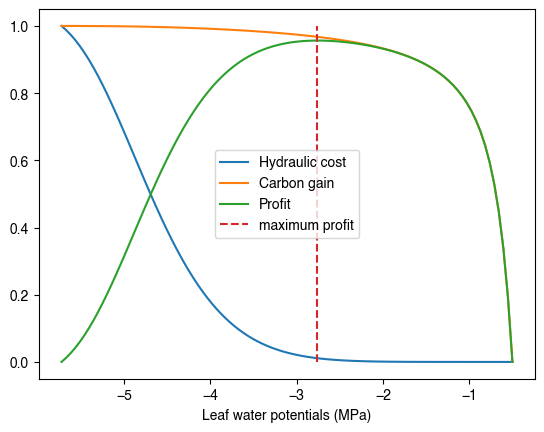

soil water potential:  -0.5  MPa
air temperature:  298.15  K
air vapour pressure deficit:  1  kPa
air pressure:  101.9  kPa
atmospheric CO2 concentration:  419.0  umol mol-1
inter cellular oxygen concentration:  210.0  umol mol-1
photosyntheticaly active radiation:  1500.0  umol m-2 s-1


In [22]:
profit_optimisation_model = ProfitOptimisationModel(hydraulic_cost_model, leaf_air_coupling_model, CO2_gain_model)

profit_values, carbon_gain, hydraulic_costs, __, __ = \
    profit_optimisation_model.profit_as_a_function_of_leaf_water_potential(water_potentials,
                                                                           soil_water_potential,
                                                                           air_temperature,
                                                                           air_vapour_pressure_deficit,
                                                                           air_pressure,
                                                                           atmospheric_CO2_concentration,
                                                                           intercellular_oxygen,
                                                                           photosyntheticaly_acitve_radiation)

maximum_profit_id = argmax(profit_values)
optimal_leaf_water_potential = water_potentials[maximum_profit_id]

plt.plot(water_potentials, hydraulic_costs, label = "Hydraulic cost")
plt.plot(water_potentials, carbon_gain, label = "Carbon gain")
plt.plot(water_potentials, profit_values, label = "Profit")
plt.plot([optimal_leaf_water_potential, optimal_leaf_water_potential], [0,1], linestyle='--', label = "maximum profit")
plt.legend()
plt.xlabel("Leaf water potentials (MPa)")
plt.ylabel("")
plt.show()

print("soil water potential: ", soil_water_potential, " MPa")
print("air temperature: ", air_temperature, " K")
print("air vapour pressure deficit: ", air_vapour_pressure_deficit, " kPa")
print("air pressure: ", air_pressure, " kPa")
print("atmospheric CO2 concentration: ", atmospheric_CO2_concentration, " umol mol-1")
print("inter cellular oxygen concentration: ", intercellular_oxygen, " umol mol-1")
print("photosyntheticaly active radiation: ", photosyntheticaly_acitve_radiation, " umol m-2 s-1")

## Comparing photosynthesis models

The plot bellow compares how the different photosynthesis limiting models affect the profit as a function of leaf water potential including maximum profit.

Optimal leaf water potentials (MPa)
Rubisco limited:  -2.770188449557864
Electron transport limited:  -2.5590081286687605
combined model:  -2.770188449557864


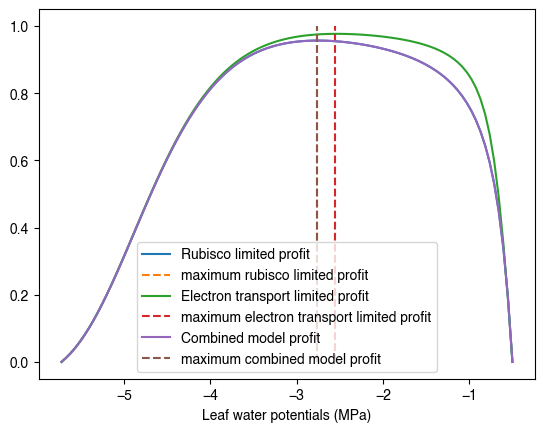

In [16]:
profit_optimisation_model_rubisco_limited = ProfitOptimisationModel(hydraulic_cost_model, leaf_air_coupling_model, CO2_gain_model_rubisco_limited)
profit_optimisation_model_electron_transport_limited = ProfitOptimisationModel(hydraulic_cost_model, leaf_air_coupling_model, CO2_gain_model_electron_transport_limited)

profit_values_rubisco_limited, carbon_gain_rubisco_limited, hydraulic_costs_rubisco_limited, __, __ = \
    profit_optimisation_model_rubisco_limited.profit_as_a_function_of_leaf_water_potential(water_potentials,
                                                                                           soil_water_potential,
                                                                                           air_temperature,
                                                                                           air_vapour_pressure_deficit,
                                                                                           air_pressure,
                                                                                           atmospheric_CO2_concentration,
                                                                                           intercellular_oxygen,
                                                                                           photosyntheticaly_acitve_radiation)

profit_values_electron_transport_limited, carbon_gain_electron_transport_limited, hydraulic_costs_electron_transport_limited, __, __ = \
    profit_optimisation_model_electron_transport_limited.profit_as_a_function_of_leaf_water_potential(water_potentials,
                                                                                                      soil_water_potential,
                                                                                                      air_temperature,
                                                                                                      air_vapour_pressure_deficit,
                                                                                                      air_pressure,
                                                                                                      atmospheric_CO2_concentration,
                                                                                                      intercellular_oxygen,
                                                                                                      photosyntheticaly_acitve_radiation)

maximum_profit_id_rubisco_limited = argmax(profit_values_rubisco_limited)
optimal_leaf_water_potential_rubisco_limited = water_potentials[maximum_profit_id_rubisco_limited]

maximum_profit_id_electron_transport_limited = argmax(profit_values_electron_transport_limited)
optimal_leaf_water_potential_electron_transport_limited = water_potentials[maximum_profit_id_electron_transport_limited]

print("Optimal leaf water potentials (MPa)")
print("Rubisco limited: ", optimal_leaf_water_potential_rubisco_limited)
print("Electron transport limited: ", optimal_leaf_water_potential_electron_transport_limited)
print("combined model: ", optimal_leaf_water_potential)

plt.plot(water_potentials, profit_values_rubisco_limited, label = "Rubisco limited profit")
plt.plot([optimal_leaf_water_potential_rubisco_limited, optimal_leaf_water_potential_rubisco_limited], [0,1], linestyle='--', label = "maximum rubisco limited profit")
plt.plot(water_potentials, profit_values_electron_transport_limited, label = "Electron transport limited profit")
plt.plot([optimal_leaf_water_potential_electron_transport_limited, optimal_leaf_water_potential_electron_transport_limited], [0,1], linestyle='--', label = "maximum electron transport limited profit")
plt.plot(water_potentials, profit_values, label = "Combined model profit")
plt.plot([optimal_leaf_water_potential, optimal_leaf_water_potential], [0,1], linestyle='--', label = "maximum combined model profit")
plt.legend()
plt.xlabel("Leaf water potentials (MPa)")
plt.ylabel("")
plt.show()

# Varying environmental condictions

Now we have a model for calulating the optimal leaf water potential ($\psi_{leaf\_opt}$) along with corresponding net $CO_2$ uptake ($A_{n\_opt}$) and transpiration rate ($E_{opt}$), we can investigate how changing the environmental conditions affects these values.

## Soil water potential

First lets vary the soil water potential

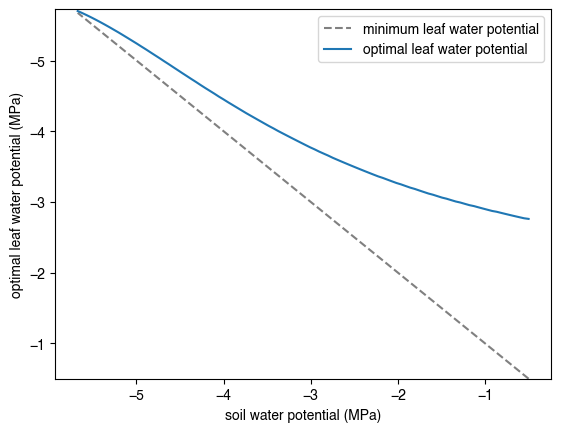

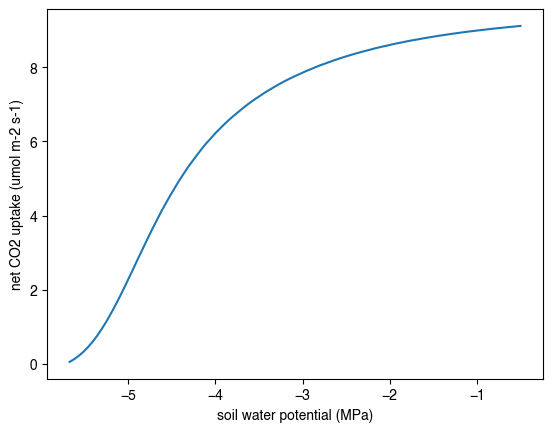

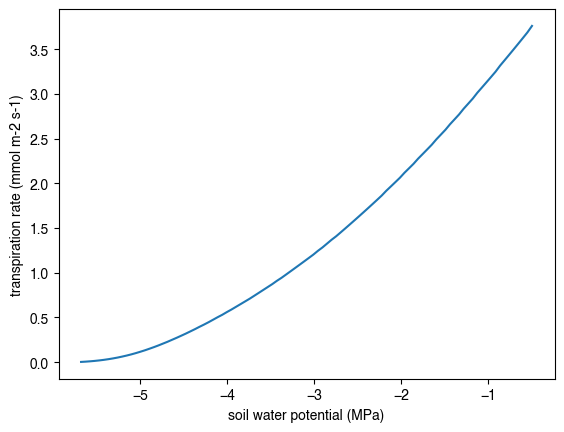

In [17]:
minimum_soil_water_potential = -0.5 # MPa
maximum_soil_water_potential = critical_water_potential # MPa

soil_water_potentials = linspace(minimum_soil_water_potential,
                                 maximum_soil_water_potential,
                                 num = 100,
                                 endpoint = False) # MPa

optimal_leaf_water_potentials = zeros(len(soil_water_potentials))
net_CO2_uptake_values = zeros(len(soil_water_potentials))
transpiration_rates = zeros(len(soil_water_potentials))

for i in range(len(soil_water_potentials)):
    optimal_leaf_water_potentials[i], net_CO2_uptake_values[i], transpiration_rates[i] = \
        profit_optimisation_model.optimal_state(soil_water_potentials[i],
                                                air_temperature,
                                                air_vapour_pressure_deficit,
                                                air_pressure,
                                                atmospheric_CO2_concentration,
                                                intercellular_oxygen,
                                                photosyntheticaly_acitve_radiation)

# Leaf water potential
plt.plot(soil_water_potentials, soil_water_potentials,
         linestyle = "--", label = "minimum leaf water potential", c = "grey")
plt.plot(soil_water_potentials, optimal_leaf_water_potentials,
         label = "optimal leaf water potential")

plt.legend()
plt.xlabel("soil water potential (MPa)")
plt.ylabel("optimal leaf water potential (MPa)")
plt.ylim(minimum_soil_water_potential, critical_water_potential)
plt.show()

# net CO2 uptake
plt.plot(soil_water_potentials, net_CO2_uptake_values)
plt.xlabel("soil water potential (MPa)")
plt.ylabel("net CO2 uptake (umol m-2 s-1)")
plt.show()

# transpiration rate
plt.plot(soil_water_potentials, transpiration_rates)
plt.xlabel("soil water potential (MPa)")
plt.ylabel("transpiration rate (mmol m-2 s-1)")
plt.show()

## Air temperature

The code bellow varies the air temperature. Remeber that this nodel assumes perfect coupling between the leaf and the air such that the temperatures of the leaf and air are the same.

/Users/jb14389/Desktop/Training/Getting started with tree models/profit-optimisation-model/note books/../src/CO2_gain_model.py:64: RuntimeWarning: divide by zero encountered in divide
  CO2_gain = net_CO2_uptake / maximum_CO2_uptake
/Users/jb14389/Desktop/Training/Getting started with tree models/profit-optimisation-model/note books/../src/CO2_gain_model.py:64: RuntimeWarning: invalid value encountered in divide
  CO2_gain = net_CO2_uptake / maximum_CO2_uptake


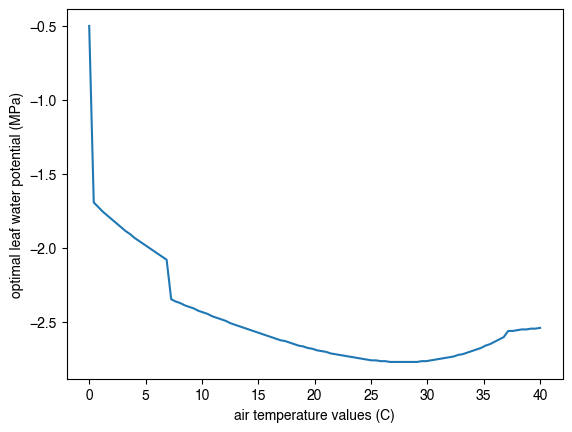

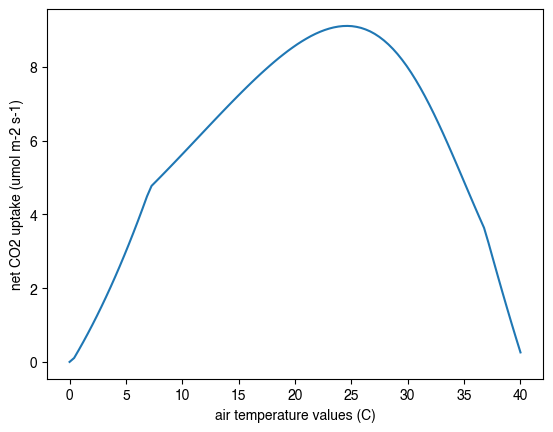

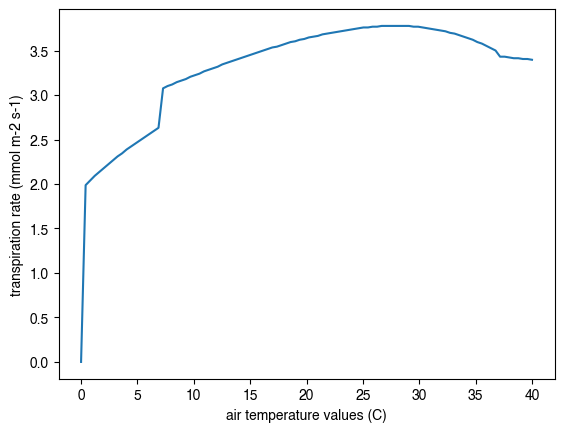

In [18]:
minimum_air_temperature =   0. # C
maximum_air_temperature =  40. # C

air_temperature_values_C = linspace(minimum_air_temperature,
                                    maximum_air_temperature,
                                    num = 100) # C

air_temperature_values_K = degrees_centigrade_to_kelvin(air_temperature_values_C)

optimal_leaf_water_potentials = zeros(len(air_temperature_values_K))
net_CO2_uptake_values = zeros(len(air_temperature_values_K))
transpiration_rates = zeros(len(air_temperature_values_K))

for i in range(len(air_temperature_values_K)):
    optimal_leaf_water_potentials[i], net_CO2_uptake_values[i], transpiration_rates[i] = \
        profit_optimisation_model.optimal_state(soil_water_potential,
                                                air_temperature_values_K[i],
                                                air_vapour_pressure_deficit,
                                                air_pressure,
                                                atmospheric_CO2_concentration,
                                                intercellular_oxygen,
                                                photosyntheticaly_acitve_radiation)

# Leaf water potential
plt.plot(air_temperature_values_C, optimal_leaf_water_potentials)
plt.xlabel("air temperature values (C)")
plt.ylabel("optimal leaf water potential (MPa)")
plt.show()

# net CO2 uptake
plt.plot(air_temperature_values_C, net_CO2_uptake_values)
plt.xlabel("air temperature values (C)")
plt.ylabel("net CO2 uptake (umol m-2 s-1)")
plt.show()

# transpiration rate
plt.plot(air_temperature_values_C, transpiration_rates)
plt.xlabel("air temperature values (C)")
plt.ylabel("transpiration rate (mmol m-2 s-1)")
plt.show()

Of note here are the sharp changes in gradient. These are non-physical and introduced due to aproximations in the model. The causes include the low temperature adjustment to the electron transport rate model and the points at which the system changes between being electron transport limited and rubisco rate limited and vis versa.

## Air vapour pressure deficit

The code below varies the vapour pressure defecit of the air.

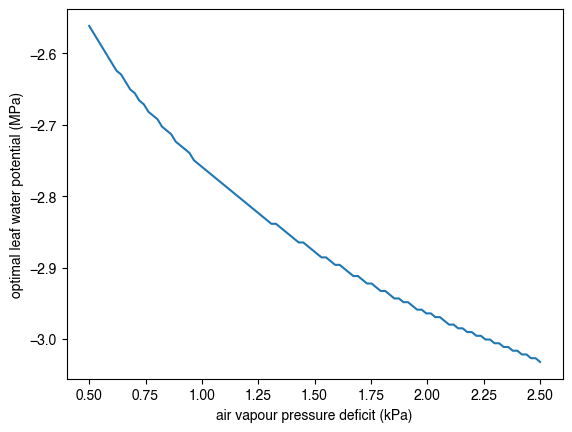

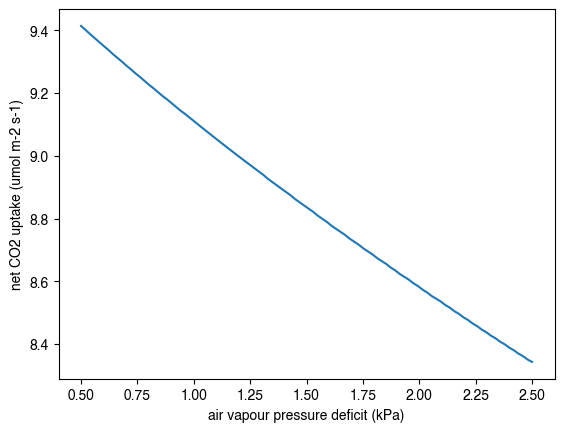

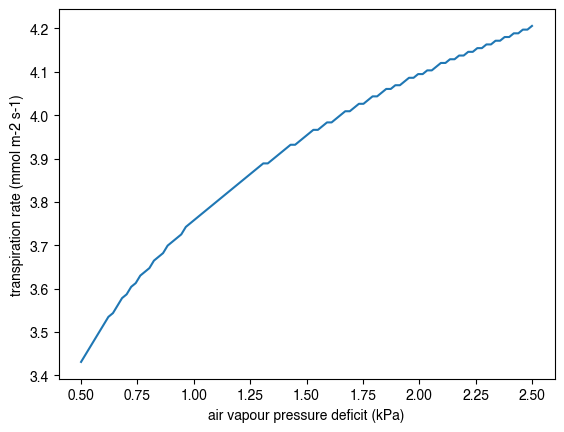

In [19]:
minimum_air_vapour_pressure_deficit = 0.5 # kPa
maximum_air_vapour_pressure_deficit = 2.5 # kPa

air_vapour_pressure_deficit_values = linspace(minimum_air_vapour_pressure_deficit,
                                              maximum_air_vapour_pressure_deficit,
                                              num = 100) # kPa

optimal_leaf_water_potentials = zeros(len(air_vapour_pressure_deficit_values))
net_CO2_uptake_values = zeros(len(air_vapour_pressure_deficit_values))
transpiration_rates = zeros(len(air_vapour_pressure_deficit_values))

for i in range(len(air_vapour_pressure_deficit_values)):
    optimal_leaf_water_potentials[i], net_CO2_uptake_values[i], transpiration_rates[i] = \
        profit_optimisation_model.optimal_state(soil_water_potential,
                                                air_temperature,
                                                air_vapour_pressure_deficit_values[i],
                                                air_pressure,
                                                atmospheric_CO2_concentration,
                                                intercellular_oxygen,
                                                photosyntheticaly_acitve_radiation)

# Leaf water potential
plt.plot(air_vapour_pressure_deficit_values, optimal_leaf_water_potentials)
plt.xlabel("air vapour pressure deficit (kPa)")
plt.ylabel("optimal leaf water potential (MPa)")
plt.show()

# net CO2 uptake
plt.plot(air_vapour_pressure_deficit_values, net_CO2_uptake_values)
plt.xlabel("air vapour pressure deficit (kPa)")
plt.ylabel("net CO2 uptake (umol m-2 s-1)")
plt.show()

# transpiration rate
plt.plot(air_vapour_pressure_deficit_values, transpiration_rates)
plt.xlabel("air vapour pressure deficit (kPa)")
plt.ylabel("transpiration rate (mmol m-2 s-1)")
plt.show()

## Air pressure

The code bellow varies air pressure. We see a set of clear steps in the results which is not natural. This will be caused by an aproximation used when calculating the roots of the quadratic. Similar sets of steps can be seen in the plots above though less prenounced. It is not possibl to remove these but they can be reduced by improving the precision of the quadratic solver.

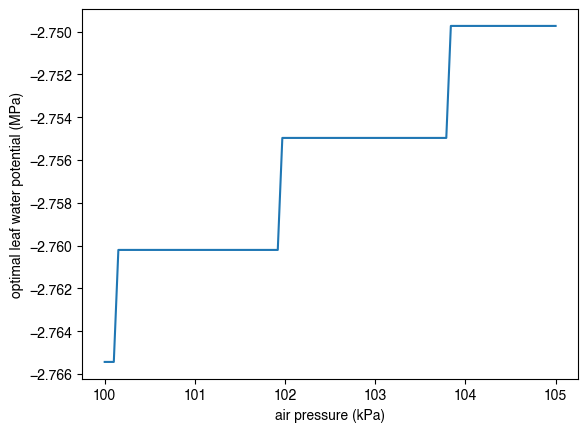

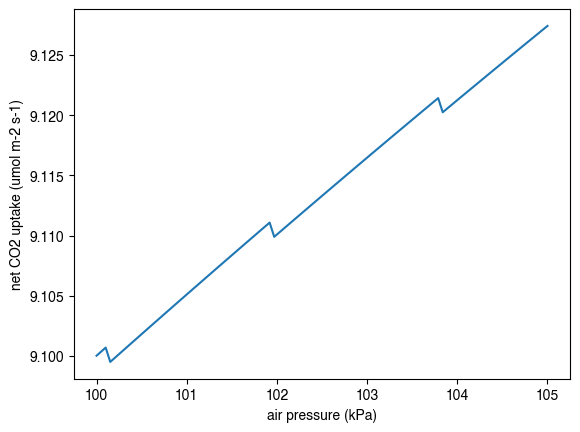

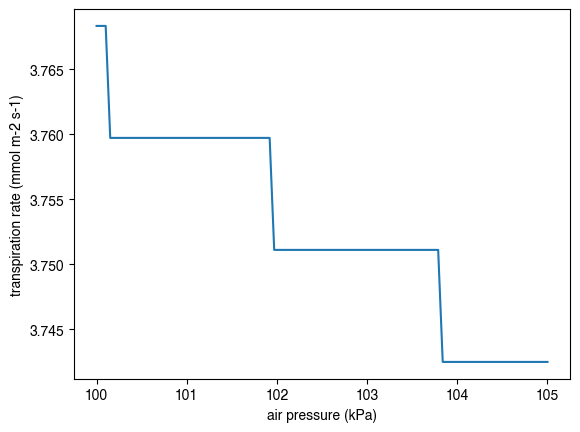

In [20]:
minimum_air_pressure = 100. # kPa
maximum_air_pressure = 105. # kPa

air_pressure_values = linspace(minimum_air_pressure,
                               maximum_air_pressure,
                               num = 100) # kPa

optimal_leaf_water_potentials = zeros(len(air_pressure_values))
net_CO2_uptake_values = zeros(len(air_pressure_values))
transpiration_rates = zeros(len(air_pressure_values))

for i in range(len(air_pressure_values)):
    optimal_leaf_water_potentials[i], net_CO2_uptake_values[i], transpiration_rates[i] = \
        profit_optimisation_model.optimal_state(soil_water_potential,
                                                air_temperature,
                                                air_vapour_pressure_deficit,
                                                air_pressure_values[i],
                                                atmospheric_CO2_concentration,
                                                intercellular_oxygen,
                                                photosyntheticaly_acitve_radiation)

# Leaf water potential
plt.plot(air_pressure_values, optimal_leaf_water_potentials)
plt.xlabel("air pressure (kPa)")
plt.ylabel("optimal leaf water potential (MPa)")
plt.show()

# net CO2 uptake
plt.plot(air_pressure_values, net_CO2_uptake_values)
plt.xlabel("air pressure (kPa)")
plt.ylabel("net CO2 uptake (umol m-2 s-1)")
plt.show()

# transpiration rate
plt.plot(air_pressure_values, transpiration_rates)
plt.xlabel("air pressure (kPa)")
plt.ylabel("transpiration rate (mmol m-2 s-1)")
plt.show()

## Atmospheric CO2 concentration

The code bellow varies the atmospheric $CO_2$ concentration and plots its affect on the optimal leaf water potential.

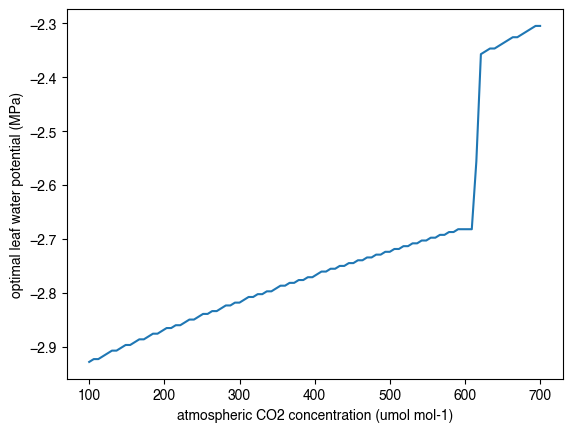

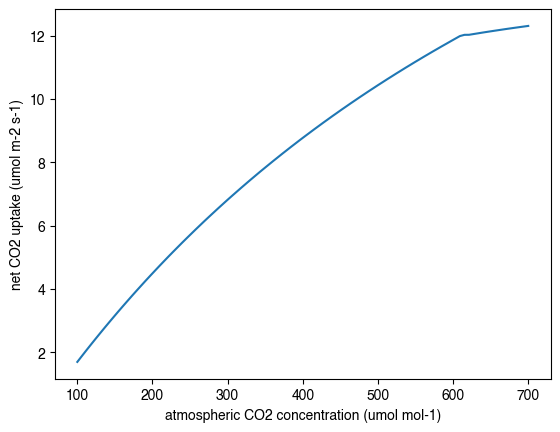

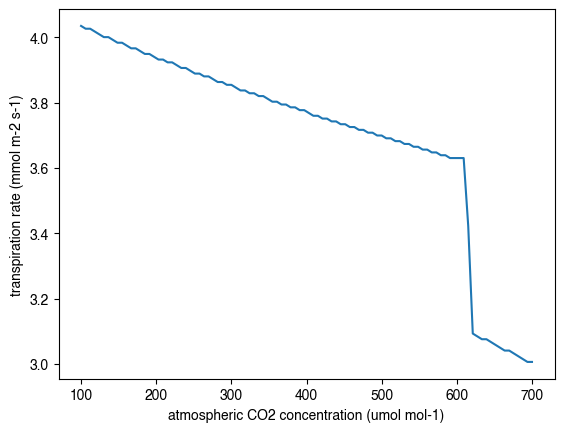

In [21]:
minimum_atmospheric_CO2_concentration = 100. # (umol mol-1)
maximum_atmospheric_CO2_concentration = 700. # (umol mol-1)

atmospheric_CO2_concentration_values = linspace(minimum_atmospheric_CO2_concentration,
                                                maximum_atmospheric_CO2_concentration,
                                                num = 100) # kPa

optimal_leaf_water_potentials = zeros(len(atmospheric_CO2_concentration_values))
net_CO2_uptake_values = zeros(len(atmospheric_CO2_concentration_values))
transpiration_rates = zeros(len(atmospheric_CO2_concentration_values))

for i in range(len(atmospheric_CO2_concentration_values)):
    optimal_leaf_water_potentials[i], net_CO2_uptake_values[i], transpiration_rates[i] = \
        profit_optimisation_model.optimal_state(soil_water_potential,
                                                air_temperature,
                                                air_vapour_pressure_deficit,
                                                air_pressure,
                                                atmospheric_CO2_concentration_values[i],
                                                intercellular_oxygen,
                                                photosyntheticaly_acitve_radiation)

# Leaf water potential
plt.plot(atmospheric_CO2_concentration_values, optimal_leaf_water_potentials)
plt.xlabel("atmospheric CO2 concentration (umol mol-1)")
plt.ylabel("optimal leaf water potential (MPa)")
plt.show()

# net CO2 uptake
plt.plot(atmospheric_CO2_concentration_values, net_CO2_uptake_values)
plt.xlabel("atmospheric CO2 concentration (umol mol-1)")
plt.ylabel("net CO2 uptake (umol m-2 s-1)")
plt.show()

# transpiration rate
plt.plot(atmospheric_CO2_concentration_values, transpiration_rates)
plt.xlabel("atmospheric CO2 concentration (umol mol-1)")
plt.ylabel("transpiration rate (mmol m-2 s-1)")
plt.show()